In [ ]:
import json
import numpy as np
from collections import Counter

def calculate_entropy(probs):
    """Calculate entropy of a probability distribution"""
    probs = np.array(probs)
    # Remove zeros to avoid log(0)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log(probs))

matches = 0
mismatches = 0
type_counts = Counter()
match_entropies = []
mismatch_entropies = []
match_max_probs = []
mismatch_max_probs = []

path = "fine_tune_logs/2025-11-30-19-40-55_meta-llama-Meta-Llama-3-8B-Instruct_evaluation_metrics.jsonl"

with open(path, 'r') as f:
    for line in f:
        if line.strip():
            data = json.loads(line)
            entry_type = data.get('type')
            if entry_type:
                type_counts[entry_type] += 1
            
            # Calculate entropy for match/mismatch entries
            if entry_type in ['model_answer_match', 'model_answer_mismatch']:
                predicted_probs = data.get('predicted_probs')
                if predicted_probs:
                    entropy = calculate_entropy(predicted_probs)
                    max_prob = np.max(predicted_probs)
                    if entry_type == 'model_answer_match':
                        matches += 1
                        match_entropies.append(entropy)
                        match_max_probs.append(max_prob)
                    elif entry_type == 'model_answer_mismatch':
                        mismatches += 1
                        mismatch_entropies.append(entropy)
                        mismatch_max_probs.append(max_prob)

total = matches + mismatches
match_percentage = (matches / total * 100) if total > 0 else 0

avg_match_entropy = np.mean(match_entropies) if match_entropies else 0
avg_mismatch_entropy = np.mean(mismatch_entropies) if mismatch_entropies else 0
avg_match_max_prob = np.mean(match_max_probs) if match_max_probs else 0
avg_mismatch_max_prob = np.mean(mismatch_max_probs) if mismatch_max_probs else 0

print(f"Matches: {matches}")
print(f"Mismatches: {mismatches}")
print(f"Total: {total}")
print(f"Match percentage: {match_percentage:.2f}%")
print(f"\nAverage entropy for model_answer_match: {avg_match_entropy:.4f}")
print(f"Average entropy for model_answer_mismatch: {avg_mismatch_entropy:.4f}")
print(f"\nAverage max probability for model_answer_match: {avg_match_max_prob:.4f}")
print(f"Average max probability for model_answer_mismatch: {avg_mismatch_max_prob:.4f}")
print("\nLog message type counts:")
for log_type, count in sorted(type_counts.items()):
    print(f"  {log_type}: {count}")


Matches: 0
Mismatches: 0
Total: 0
Match percentage: 0.00%

Average entropy for model_answer_match: 0.0000
Average entropy for model_answer_mismatch: 0.0000

Average max probability for model_answer_match: 0.0000
Average max probability for model_answer_mismatch: 0.0000

Log message type counts:
  eval_sample: 6625
  eval_summary: 26


In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

file_path = 'fine_tune_logs/meta-llama-Meta-Llama-3-8B-Instruct_2025-11-29-00-26-39_mcq_accuracy_assessment.jsonl'

# Load data
mcq_data = []
confidence_data = []
paired_data = {}  # qid -> {mcq: ..., confidence: ...}

with open(file_path, 'r') as f:
    for line in f:
        if line.strip():
            data = json.loads(line)
            entry_type = data.get('type')
            qid = data.get('qid')
            
            if entry_type == 'mcq_accuracy_assessment':
                mcq_data.append(data)
                if qid not in paired_data:
                    paired_data[qid] = {}
                paired_data[qid]['mcq'] = data
            elif entry_type == 'confidence_assessment':
                confidence_data.append(data)
                if qid not in paired_data:
                    paired_data[qid] = {}
                paired_data[qid]['confidence'] = data

print(f"Total MCQ assessments: {len(mcq_data)}")
print(f"Total Confidence assessments: {len(confidence_data)}")
print(f"Paired entries: {len([p for p in paired_data.values() if 'mcq' in p and 'confidence' in p])}")

Total MCQ assessments: 25000
Total Confidence assessments: 25000
Paired entries: 1641


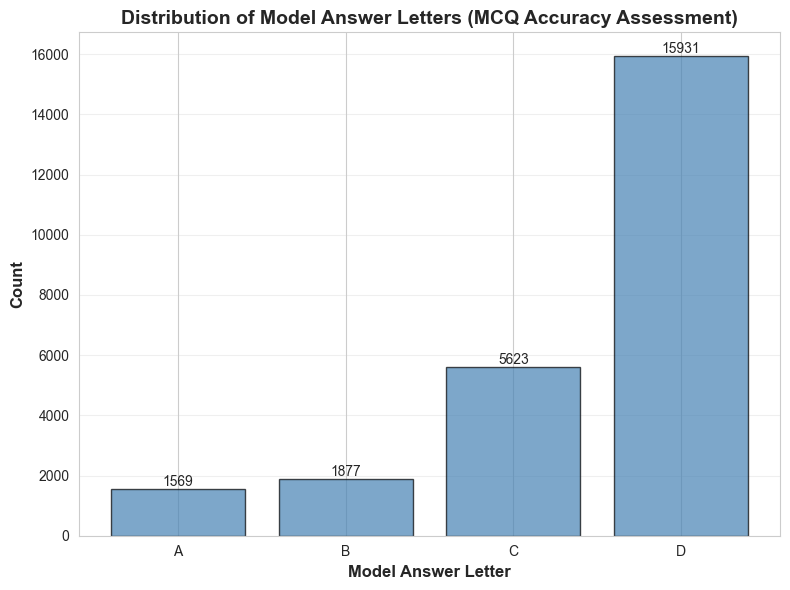


Model Answer Letter Distribution:
  A: 1569 (6.28%)
  B: 1877 (7.51%)
  C: 5623 (22.49%)
  D: 15931 (63.72%)


In [2]:
# Histogram 1: Model Answer Letters (A, B, C, D)
model_answer_letters = [entry['model_answer_letter'] for entry in mcq_data if 'model_answer_letter' in entry]
letter_counts = Counter(model_answer_letters)

fig, ax = plt.subplots(figsize=(8, 6))
letters = sorted(letter_counts.keys())
counts = [letter_counts[letter] for letter in letters]
bars = ax.bar(letters, counts, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Model Answer Letter', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Model Answer Letters (MCQ Accuracy Assessment)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nModel Answer Letter Distribution:")
for letter in sorted(letter_counts.keys()):
    print(f"  {letter}: {letter_counts[letter]} ({letter_counts[letter]/len(model_answer_letters)*100:.2f}%)")


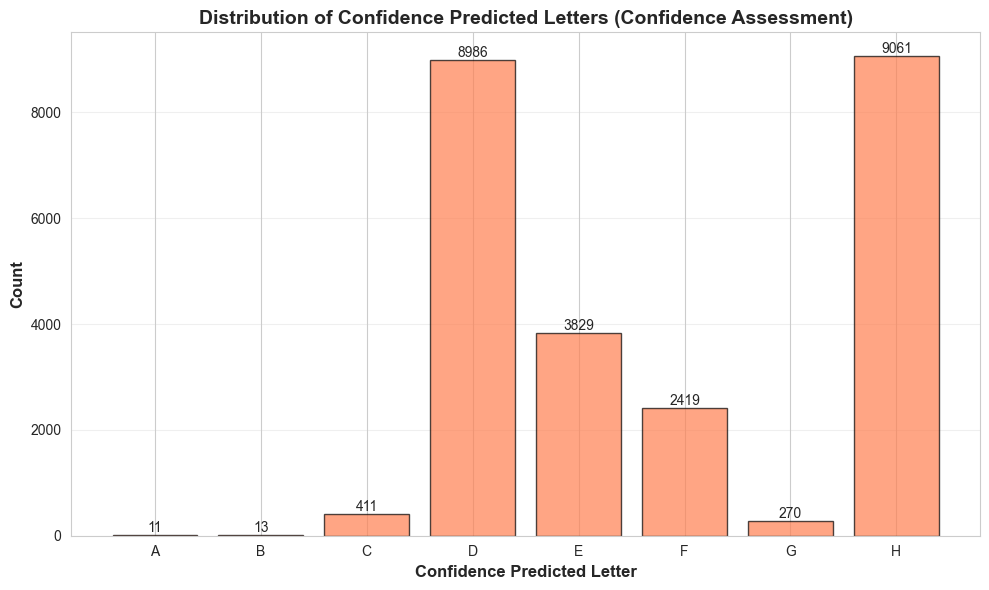


Confidence Predicted Letter Distribution:
  A: 11 (0.04%)
  B: 13 (0.05%)
  C: 411 (1.64%)
  D: 8986 (35.94%)
  E: 3829 (15.32%)
  F: 2419 (9.68%)
  G: 270 (1.08%)
  H: 9061 (36.24%)


In [3]:
# Histogram 2: Confidence Predicted Letters (A-H)
confidence_letters = [entry['confidence_predicted_letter'] for entry in confidence_data if 'confidence_predicted_letter' in entry]
confidence_letter_counts = Counter(confidence_letters)

fig, ax = plt.subplots(figsize=(10, 6))
letters = sorted(confidence_letter_counts.keys())
counts = [confidence_letter_counts[letter] for letter in letters]
bars = ax.bar(letters, counts, color='coral', alpha=0.7, edgecolor='black')
ax.set_xlabel('Confidence Predicted Letter', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Confidence Predicted Letters (Confidence Assessment)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nConfidence Predicted Letter Distribution:")
for letter in sorted(confidence_letter_counts.keys()):
    print(f"  {letter}: {confidence_letter_counts[letter]} ({confidence_letter_counts[letter]/len(confidence_letters)*100:.2f}%)")


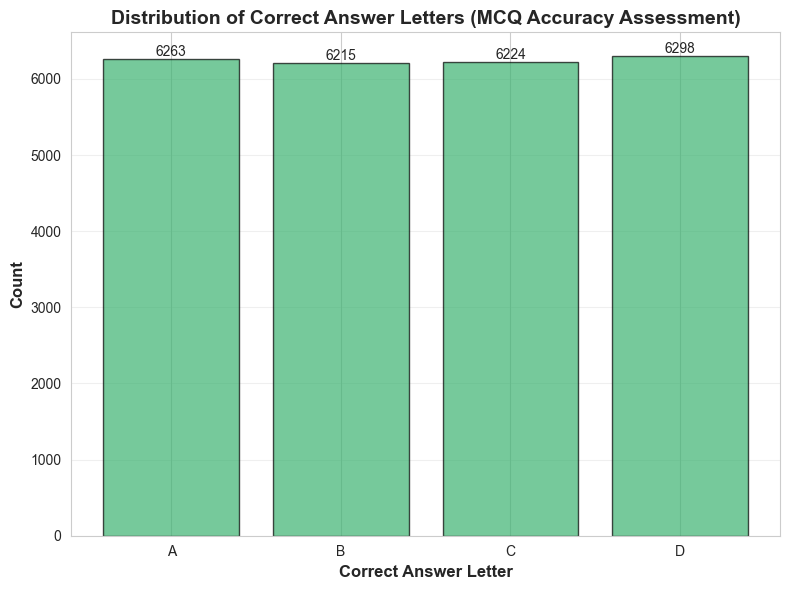


Correct Answer Letter Distribution:
  A: 6263 (25.05%)
  B: 6215 (24.86%)
  C: 6224 (24.90%)
  D: 6298 (25.19%)


In [12]:
# Histogram 3: Correct Answer Letters (A, B, C, D)
correct_answer_letters = [entry['correct_answer_letter'] for entry in mcq_data if 'correct_answer_letter' in entry]
correct_letter_counts = Counter(correct_answer_letters)

fig, ax = plt.subplots(figsize=(8, 6))
letters = sorted(correct_letter_counts.keys())
counts = [correct_letter_counts[letter] for letter in letters]
bars = ax.bar(letters, counts, color='mediumseagreen', alpha=0.7, edgecolor='black')
ax.set_xlabel('Correct Answer Letter', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Correct Answer Letters (MCQ Accuracy Assessment)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nCorrect Answer Letter Distribution:")
for letter in sorted(correct_letter_counts.keys()):
    print(f"  {letter}: {correct_letter_counts[letter]} ({correct_letter_counts[letter]/len(correct_answer_letters)*100:.2f}%)")


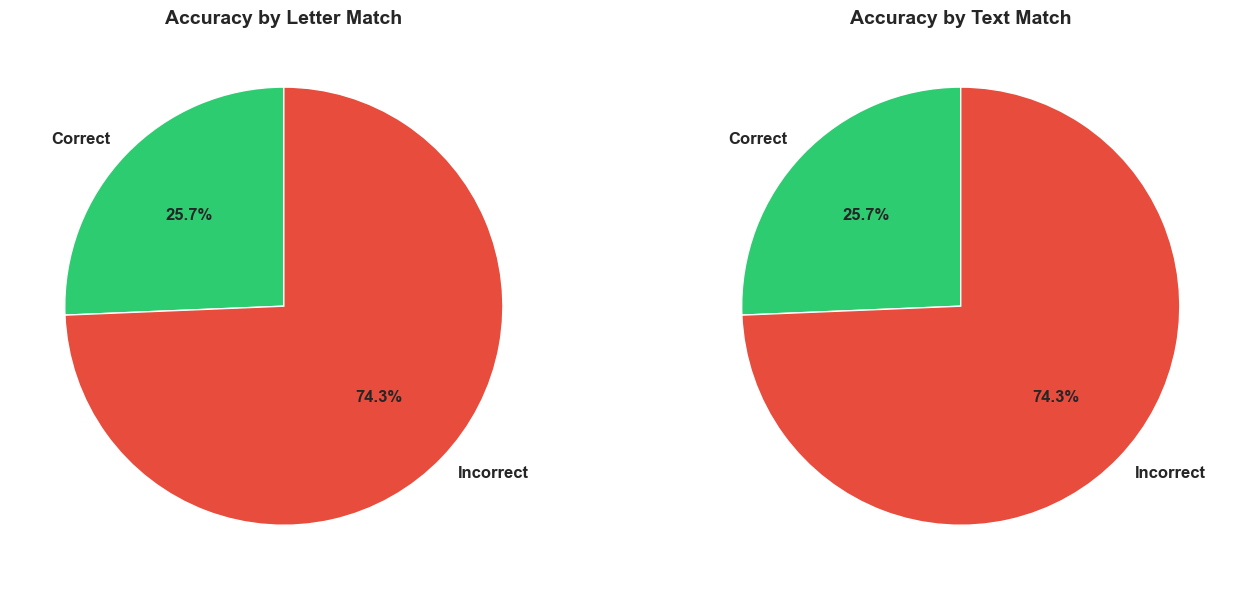


Accuracy Statistics:
  Correct by letter: 6413/25000 (25.65%)
  Correct by text: 6413/25000 (25.65%)


In [4]:
# Accuracy Analysis
correct_by_letter = sum(1 for entry in mcq_data if entry.get('is_correct_by_letter', False))
correct_by_text = sum(1 for entry in mcq_data if entry.get('is_correct_by_text', False))
total_mcq = len(mcq_data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy by letter
labels = ['Correct', 'Incorrect']
sizes_letter = [correct_by_letter, total_mcq - correct_by_letter]
colors = ['#2ecc71', '#e74c3c']
ax1.pie(sizes_letter, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax1.set_title('Accuracy by Letter Match', fontsize=14, fontweight='bold')

# Accuracy by text
sizes_text = [correct_by_text, total_mcq - correct_by_text]
ax2.pie(sizes_text, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Accuracy by Text Match', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nAccuracy Statistics:")
print(f"  Correct by letter: {correct_by_letter}/{total_mcq} ({correct_by_letter/total_mcq*100:.2f}%)")
print(f"  Correct by text: {correct_by_text}/{total_mcq} ({correct_by_text/total_mcq*100:.2f}%)")


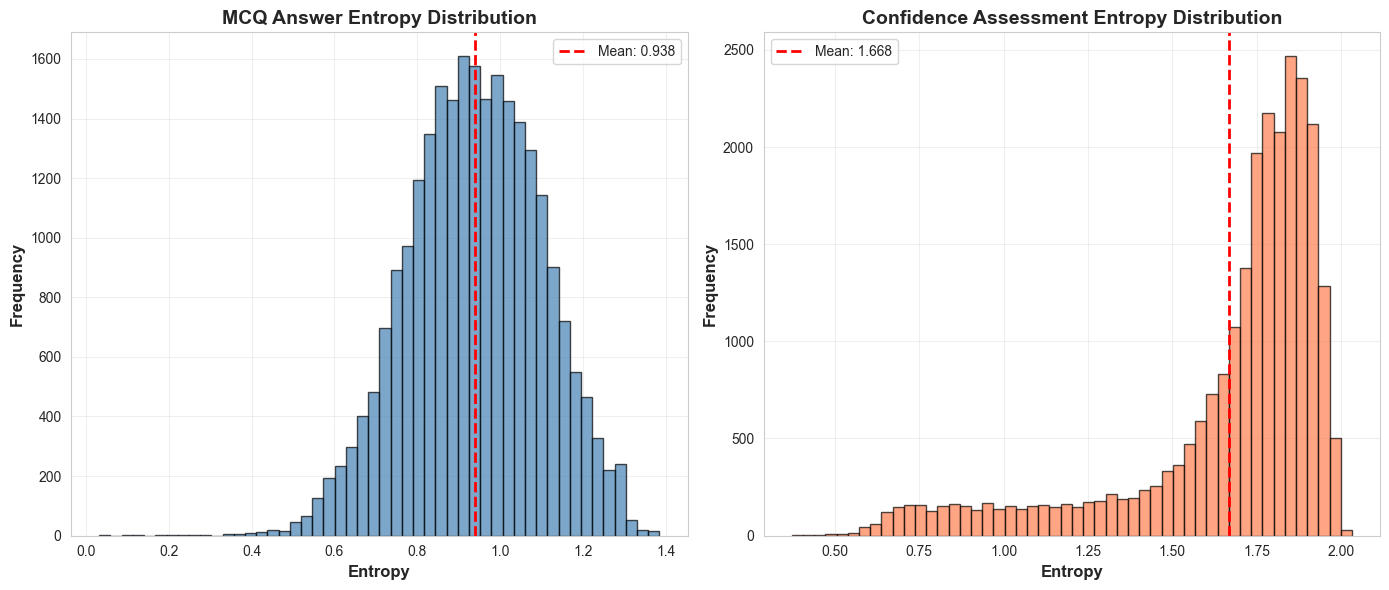


Entropy Statistics:
  MCQ Entropy - Mean: 0.9379, Std: 0.1610, Min: 0.0328, Max: 1.3839
  Confidence Entropy - Mean: 1.6683, Std: 0.3095, Min: 0.3721, Max: 2.0324


In [5]:
# Entropy Analysis
mcq_entropies = [entry['entropy'] for entry in mcq_data if 'entropy' in entry]
confidence_entropies = [entry['confidence_entropy'] for entry in confidence_data if 'confidence_entropy' in entry]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# MCQ Entropy distribution
ax1.hist(mcq_entropies, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(mcq_entropies), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(mcq_entropies):.3f}')
ax1.set_xlabel('Entropy', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('MCQ Answer Entropy Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Confidence Entropy distribution
ax2.hist(confidence_entropies, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(confidence_entropies), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(confidence_entropies):.3f}')
ax2.set_xlabel('Entropy', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Confidence Assessment Entropy Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEntropy Statistics:")
print(f"  MCQ Entropy - Mean: {np.mean(mcq_entropies):.4f}, Std: {np.std(mcq_entropies):.4f}, Min: {np.min(mcq_entropies):.4f}, Max: {np.max(mcq_entropies):.4f}")
print(f"  Confidence Entropy - Mean: {np.mean(confidence_entropies):.4f}, Std: {np.std(confidence_entropies):.4f}, Min: {np.min(confidence_entropies):.4f}, Max: {np.max(confidence_entropies):.4f}")


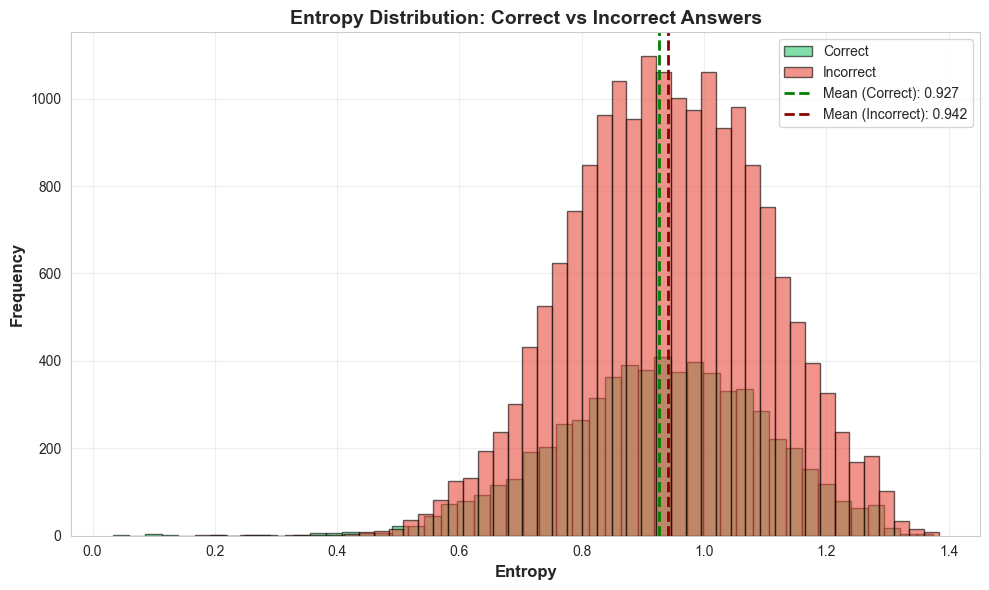


Entropy by Accuracy:
  Correct answers - Mean entropy: 0.9272, Std: 0.1698
  Incorrect answers - Mean entropy: 0.9416, Std: 0.1577


In [6]:
# Entropy vs Accuracy
correct_entropies = [entry['entropy'] for entry in mcq_data if entry.get('is_correct_by_letter', False) and 'entropy' in entry]
incorrect_entropies = [entry['entropy'] for entry in mcq_data if not entry.get('is_correct_by_letter', False) and 'entropy' in entry]

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(correct_entropies, bins=50, alpha=0.6, label='Correct', color='#2ecc71', edgecolor='black')
ax.hist(incorrect_entropies, bins=50, alpha=0.6, label='Incorrect', color='#e74c3c', edgecolor='black')
ax.axvline(np.mean(correct_entropies), color='green', linestyle='--', linewidth=2, label=f'Mean (Correct): {np.mean(correct_entropies):.3f}')
ax.axvline(np.mean(incorrect_entropies), color='darkred', linestyle='--', linewidth=2, label=f'Mean (Incorrect): {np.mean(incorrect_entropies):.3f}')
ax.set_xlabel('Entropy', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Entropy Distribution: Correct vs Incorrect Answers', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nEntropy by Accuracy:")
print(f"  Correct answers - Mean entropy: {np.mean(correct_entropies):.4f}, Std: {np.std(correct_entropies):.4f}")
print(f"  Incorrect answers - Mean entropy: {np.mean(incorrect_entropies):.4f}, Std: {np.std(incorrect_entropies):.4f}")


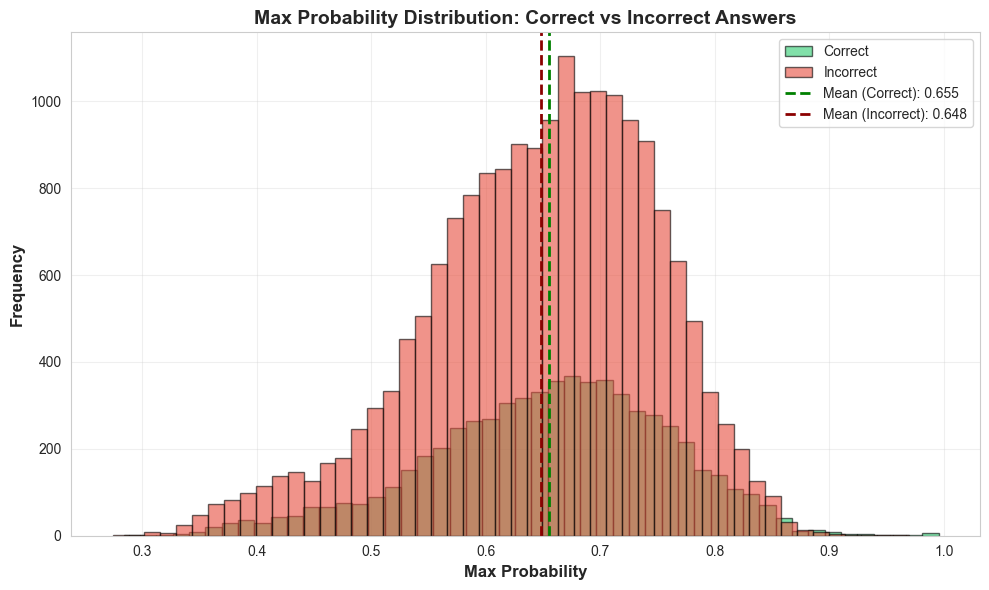


Max Probability by Accuracy:
  Correct answers - Mean: 0.6553, Std: 0.1046
  Incorrect answers - Mean: 0.6478, Std: 0.1004


In [8]:
# Max Probability Analysis
max_probs = []
for entry in mcq_data:
    if 'probabilities' in entry:
        probs = list(entry['probabilities'].values())
        max_probs.append(max(probs))

correct_max_probs = []
incorrect_max_probs = []
for entry in mcq_data:
    if 'probabilities' in entry:
        probs = list(entry['probabilities'].values())
        max_prob = max(probs)
        if entry.get('is_correct_by_letter', False):
            correct_max_probs.append(max_prob)
        else:
            incorrect_max_probs.append(max_prob)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(correct_max_probs, bins=50, alpha=0.6, label='Correct', color='#2ecc71', edgecolor='black')
ax.hist(incorrect_max_probs, bins=50, alpha=0.6, label='Incorrect', color='#e74c3c', edgecolor='black')
ax.axvline(np.mean(correct_max_probs), color='green', linestyle='--', linewidth=2, label=f'Mean (Correct): {np.mean(correct_max_probs):.3f}')
ax.axvline(np.mean(incorrect_max_probs), color='darkred', linestyle='--', linewidth=2, label=f'Mean (Incorrect): {np.mean(incorrect_max_probs):.3f}')
ax.set_xlabel('Max Probability', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Max Probability Distribution: Correct vs Incorrect Answers', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMax Probability by Accuracy:")
print(f"  Correct answers - Mean: {np.mean(correct_max_probs):.4f}, Std: {np.std(correct_max_probs):.4f}")
print(f"  Incorrect answers - Mean: {np.mean(incorrect_max_probs):.4f}, Std: {np.std(incorrect_max_probs):.4f}")


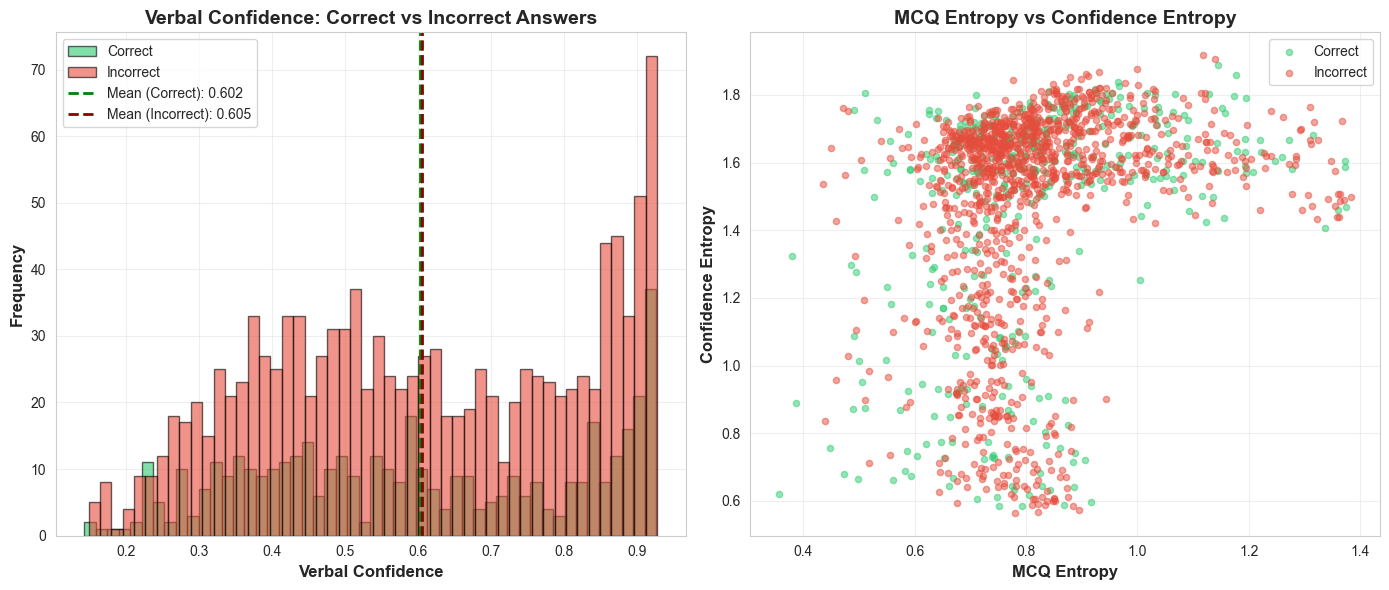


Verbal Confidence by Accuracy:
  Correct answers - Mean: 0.6024, Std: 0.2217
  Incorrect answers - Mean: 0.6050, Std: 0.2137


In [9]:
# Confidence vs Accuracy Relationship
paired_entries = [(p['mcq'], p['confidence']) for p in paired_data.values() if 'mcq' in p and 'confidence' in p]

verbal_confidences = []
is_correct_list = []
confidence_entropies_paired = []
mcq_entropies_paired = []

for mcq, conf in paired_entries:
    verbal_confidences.append(conf.get('verbal_confidence', 0))
    is_correct_list.append(mcq.get('is_correct_by_letter', False))
    confidence_entropies_paired.append(conf.get('confidence_entropy', 0))
    mcq_entropies_paired.append(mcq.get('entropy', 0))

correct_confidences = [v for v, c in zip(verbal_confidences, is_correct_list) if c]
incorrect_confidences = [v for v, c in zip(verbal_confidences, is_correct_list) if not c]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Verbal confidence distribution
ax1.hist(correct_confidences, bins=50, alpha=0.6, label='Correct', color='#2ecc71', edgecolor='black')
ax1.hist(incorrect_confidences, bins=50, alpha=0.6, label='Incorrect', color='#e74c3c', edgecolor='black')
ax1.axvline(np.mean(correct_confidences), color='green', linestyle='--', linewidth=2, label=f'Mean (Correct): {np.mean(correct_confidences):.3f}')
ax1.axvline(np.mean(incorrect_confidences), color='darkred', linestyle='--', linewidth=2, label=f'Mean (Incorrect): {np.mean(incorrect_confidences):.3f}')
ax1.set_xlabel('Verbal Confidence', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Verbal Confidence: Correct vs Incorrect Answers', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Scatter: MCQ Entropy vs Confidence Entropy
correct_mask = np.array(is_correct_list)
ax2.scatter(np.array(mcq_entropies_paired)[correct_mask], np.array(confidence_entropies_paired)[correct_mask], 
           alpha=0.5, label='Correct', color='#2ecc71', s=20)
ax2.scatter(np.array(mcq_entropies_paired)[~correct_mask], np.array(confidence_entropies_paired)[~correct_mask], 
           alpha=0.5, label='Incorrect', color='#e74c3c', s=20)
ax2.set_xlabel('MCQ Entropy', fontsize=12, fontweight='bold')
ax2.set_ylabel('Confidence Entropy', fontsize=12, fontweight='bold')
ax2.set_title('MCQ Entropy vs Confidence Entropy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVerbal Confidence by Accuracy:")
print(f"  Correct answers - Mean: {np.mean(correct_confidences):.4f}, Std: {np.std(correct_confidences):.4f}")
print(f"  Incorrect answers - Mean: {np.mean(incorrect_confidences):.4f}, Std: {np.std(incorrect_confidences):.4f}")


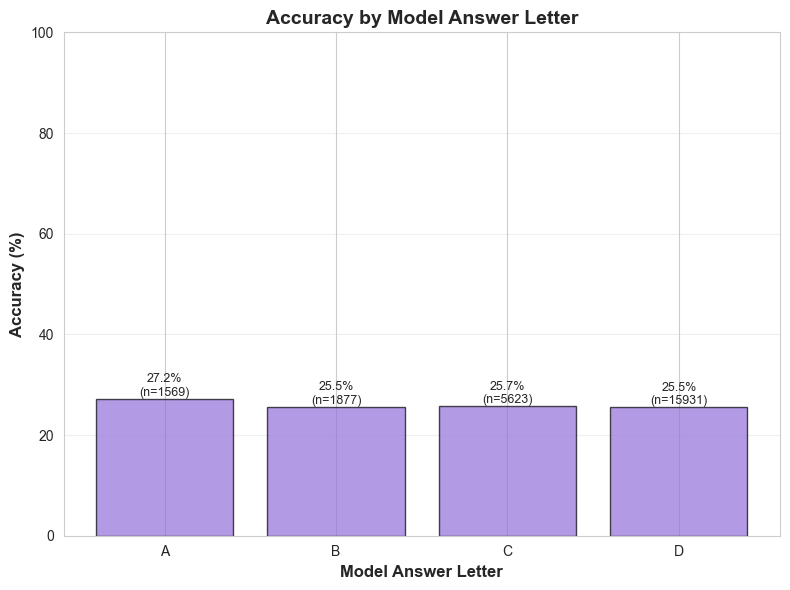


Accuracy by Model Answer Letter:
  A: 426/1569 (27.15%)
  B: 479/1877 (25.52%)
  C: 1444/5623 (25.68%)
  D: 4064/15931 (25.51%)


In [10]:
# Accuracy by Model Answer Letter
accuracy_by_letter = defaultdict(lambda: {'correct': 0, 'total': 0})

for entry in mcq_data:
    letter = entry.get('model_answer_letter')
    if letter:
        accuracy_by_letter[letter]['total'] += 1
        if entry.get('is_correct_by_letter', False):
            accuracy_by_letter[letter]['correct'] += 1

letters = sorted(accuracy_by_letter.keys())
accuracies = [accuracy_by_letter[letter]['correct'] / accuracy_by_letter[letter]['total'] * 100 
              for letter in letters]
counts = [accuracy_by_letter[letter]['total'] for letter in letters]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(letters, accuracies, color='mediumpurple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Model Answer Letter', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy by Model Answer Letter', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3)

# Add labels
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n(n={count})',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nAccuracy by Model Answer Letter:")
for letter in letters:
    acc = accuracy_by_letter[letter]['correct'] / accuracy_by_letter[letter]['total'] * 100
    print(f"  {letter}: {accuracy_by_letter[letter]['correct']}/{accuracy_by_letter[letter]['total']} ({acc:.2f}%)")


In [11]:
# Summary Statistics
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

print(f"\nDataset Overview:")
print(f"  Total MCQ assessments: {len(mcq_data)}")
print(f"  Total Confidence assessments: {len(confidence_data)}")
print(f"  Paired entries: {len(paired_entries)}")

print(f"\nAccuracy:")
print(f"  Correct by letter: {correct_by_letter}/{total_mcq} ({correct_by_letter/total_mcq*100:.2f}%)")
print(f"  Correct by text: {correct_by_text}/{total_mcq} ({correct_by_text/total_mcq*100:.2f}%)")

print(f"\nMCQ Answer Statistics:")
print(f"  Entropy - Mean: {np.mean(mcq_entropies):.4f}, Std: {np.std(mcq_entropies):.4f}")
print(f"  Max Probability - Mean: {np.mean(max_probs):.4f}, Std: {np.std(max_probs):.4f}")
print(f"  Correct answers - Mean entropy: {np.mean(correct_entropies):.4f}, Mean max prob: {np.mean(correct_max_probs):.4f}")
print(f"  Incorrect answers - Mean entropy: {np.mean(incorrect_entropies):.4f}, Mean max prob: {np.mean(incorrect_max_probs):.4f}")

print(f"\nConfidence Assessment Statistics:")
print(f"  Entropy - Mean: {np.mean(confidence_entropies):.4f}, Std: {np.std(confidence_entropies):.4f}")
if paired_entries:
    print(f"  Verbal Confidence - Mean: {np.mean(verbal_confidences):.4f}, Std: {np.std(verbal_confidences):.4f}")
    print(f"  Correct answers - Mean verbal confidence: {np.mean(correct_confidences):.4f}")
    print(f"  Incorrect answers - Mean verbal confidence: {np.mean(incorrect_confidences):.4f}")

print(f"\nModel Answer Letter Distribution:")
for letter in sorted(letter_counts.keys()):
    print(f"  {letter}: {letter_counts[letter]} ({letter_counts[letter]/len(model_answer_letters)*100:.2f}%)")

print(f"\nConfidence Predicted Letter Distribution:")
for letter in sorted(confidence_letter_counts.keys()):
    print(f"  {letter}: {confidence_letter_counts[letter]} ({confidence_letter_counts[letter]/len(confidence_letters)*100:.2f}%)")


SUMMARY STATISTICS

Dataset Overview:
  Total MCQ assessments: 25000
  Total Confidence assessments: 25000
  Paired entries: 1641

Accuracy:
  Correct by letter: 6413/25000 (25.65%)
  Correct by text: 6413/25000 (25.65%)

MCQ Answer Statistics:
  Entropy - Mean: 0.9379, Std: 0.1610
  Max Probability - Mean: 0.6497, Std: 0.1016
  Correct answers - Mean entropy: 0.9272, Mean max prob: 0.6553
  Incorrect answers - Mean entropy: 0.9416, Mean max prob: 0.6478

Confidence Assessment Statistics:
  Entropy - Mean: 1.6683, Std: 0.3095
  Verbal Confidence - Mean: 0.6043, Std: 0.2159
  Correct answers - Mean verbal confidence: 0.6024
  Incorrect answers - Mean verbal confidence: 0.6050

Model Answer Letter Distribution:
  A: 1569 (6.28%)
  B: 1877 (7.51%)
  C: 5623 (22.49%)
  D: 15931 (63.72%)

Confidence Predicted Letter Distribution:
  A: 11 (0.04%)
  B: 13 (0.05%)
  C: 411 (1.64%)
  D: 8986 (35.94%)
  E: 3829 (15.32%)
  F: 2419 (9.68%)
  G: 270 (1.08%)
  H: 9061 (36.24%)
